## Implementing SRGAN paper.
Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network
https://arxiv.org/pdf/1609.04802.pdf
                       

![srgan_results](./Figure/srgan.png)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;SRRESNET 4x upscaling&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;SRGAN 4x upscaling&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;ORIGINAL                        
                      


In [2]:
from IPython import get_ipython
if get_ipython() is not None:
    import matplotlib
    if matplotlib.get_backend() != 'agg':
      get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import tempfile

from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from glob import glob
import PIL
from PIL import Image
import numpy as np


import fastestimator as fe
from fastestimator.dataset import srgan
from fastestimator.op import TensorOp
from fastestimator.op.tensorop import Loss, ModelOp, Rescale
from fastestimator.trace import LRController, ModelSaver
from fastestimator.schedule.lr_scheduler import LRSchedule
from fastestimator.op.numpyop import ImageReader, ResizeImageAndBbox, TypeConverter
from fastestimator.layers.sub_pixel_conv_2d import SubPixelConv2D


from tensorflow.keras.layers  import Input, Conv2D, BatchNormalization, Flatten, Dense, Add, LeakyReLU
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model 
import tensorflow as tf

In [ ]:
# parameters
epochs = 100
batch_size = 4
steps_per_epoch = 2000
model_write_dir = "the dir path to write model"
model_read_dir = "the dir path to read model"
dataset_path = "the path to ImageNet dir"

### Download the ImageNet dataset. Currently the script doesn't download the ImageNet data.
ImageNet folder is expected to be in the standard format, having 'train' and 'val' subdirectories. The following script when run

- randomly selects around 350,000 images from the ImageNet dataset
- selected images are cropped to 96x96 subimages , these form the high resolution images
- High resolution images are then downsized by a factor 4 using cubic interpolation. These form the low resolution images. Low resolution image have size 24x24x3
- training csv is created along with validation csv

In [12]:
train_csv, val_csv, path = srgan.load_data(path_imgnet=dataset_path)

In [10]:
df = pd.read_csv(train_csv)
df.head()

,lowres,highres
0,/home/ubuntu/ImageNet/train_lr/n01440764_10029...,/home/ubuntu/ImageNet/train_hr/n01440764_10029...
1,/home/ubuntu/ImageNet/train_lr/n01440764_10043...,/home/ubuntu/ImageNet/train_hr/n01440764_10043...
2,/home/ubuntu/ImageNet/train_lr/n01440764_10211...,/home/ubuntu/ImageNet/train_hr/n01440764_10211...
3,/home/ubuntu/ImageNet/train_lr/n01440764_10218...,/home/ubuntu/ImageNet/train_hr/n01440764_10218...
4,/home/ubuntu/ImageNet/train_lr/n01440764_10254...,/home/ubuntu/ImageNet/train_hr/n01440764_10254...


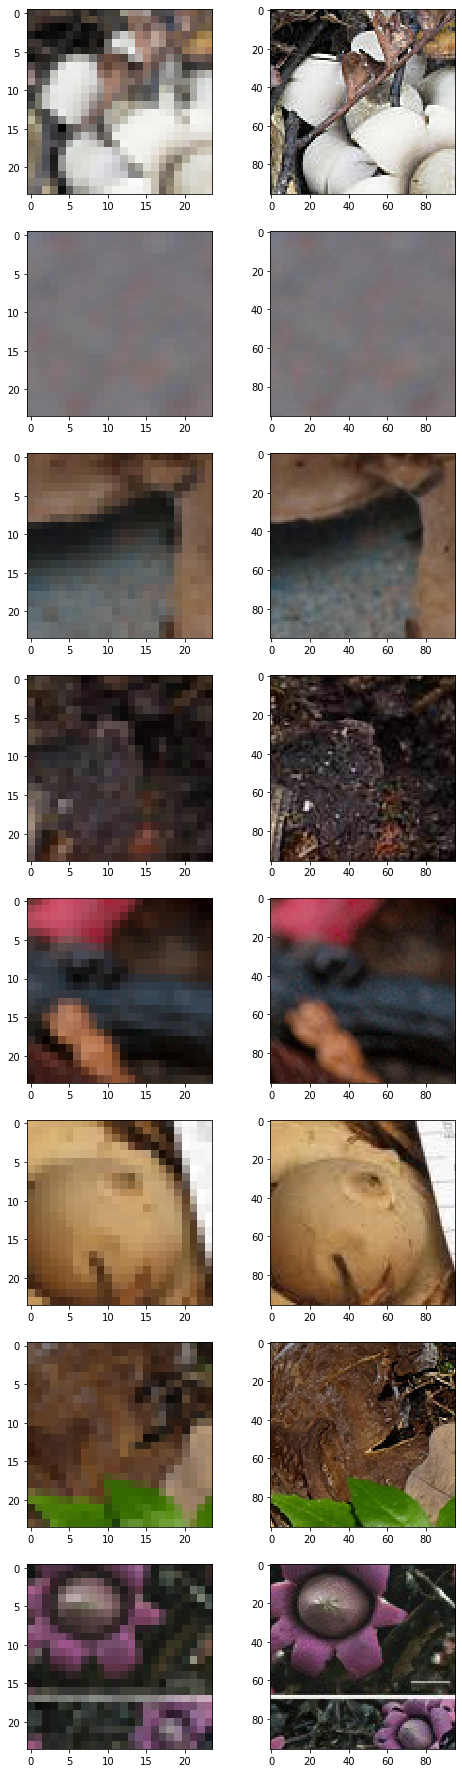

In [11]:
fig, axes = plt.subplots(nrows=8, ncols=2)
fig.set_figheight(32)
fig.set_figwidth(8)
for row,(imgpath_low, imgpath_high) in enumerate(zip(df['lowres'].values[355302:355310], 
                                                     df['highres'].values[355302:355310])):
    img_low = Image.open(imgpath_low)
    img_low = np.array(img_low)
    img_high = Image.open(imgpath_high)
    img_high = np.array(img_high)
    
    axes[row, 0].imshow(img_low)
    axes[row, 1].imshow(img_high)
plt.show()

### Preprocessing
- Preprocessing of low resolution images is carried out by LowresRescale.  Image values end up between (0,1)
- Preprocessing of high resolution images is carried out by Rescale. Image values end up between (-1,1)

In [ ]:
class LowresRescale(TensorOp):
    """Rescaling data according to

    Args:
        inputs: Name of the key in the dataset that is to be filtered.
        outputs: Name of the key to be created/used in the dataset to store the results.
        mode: mode that the filter acts on.
    """
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        data = tf.cast(data, tf.float32)
        data /= 255
        return data

### Create TF Records from high res and low res images

In [ ]:
writer = fe.RecordWriter(
        save_dir=os.path.join(path, "sr_tfrecords"),
        train_data= train_csv,
        validation_data=val_csv,
        ops=[
            ImageReader(inputs="lowres", outputs="lowres"),
            ImageReader(inputs="highres", outputs="highres")
            
        ],
        compression="GZIP",
        write_feature=[
            'lowres', 'highres'
        ])

### Create data pipeline
Please note that the batch_size is 4 . The srgan/srresnet paper stipulates that the batch size should be 16. <br> The training has been carried out in p3.8xlarge ec2 instance having 4 V100.<br>
Fastestimator leverages tf.distributed strategy, effecting the batch_size to be 16 (4 gpus * 4 batch size).

In [27]:
pipeline = fe.Pipeline(max_shuffle_buffer_mb=3000,
        batch_size=batch_size,
        data=writer,
        ops=[
            LowresRescale(inputs='lowres', outputs='lowres'),
            Rescale(inputs='highres', outputs='highres'),
            
        ])

### Check the result of preprocessing 

In [8]:
sample_batch = pipeline.show_results()

FastEstimator: Reading non-empty directory: /home/ubuntu/ImageNet/sr_tfrecords
FastEstimator: Found 357137 examples for train in /home/ubuntu/ImageNet/sr_tfrecords/train_summary0.json
FastEstimator: Found 49903 examples for eval in /home/ubuntu/ImageNet/sr_tfrecords/eval_summary0.json


FastEstimator: Reading non-empty directory: /home/ubuntu/ImageNet/sr_tfrecords
FastEstimator: Found 357137 examples for train in /home/ubuntu/ImageNet/sr_tfrecords/train_summary0.json
FastEstimator: Found 49903 examples for eval in /home/ubuntu/ImageNet/sr_tfrecords/eval_summary0.json


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

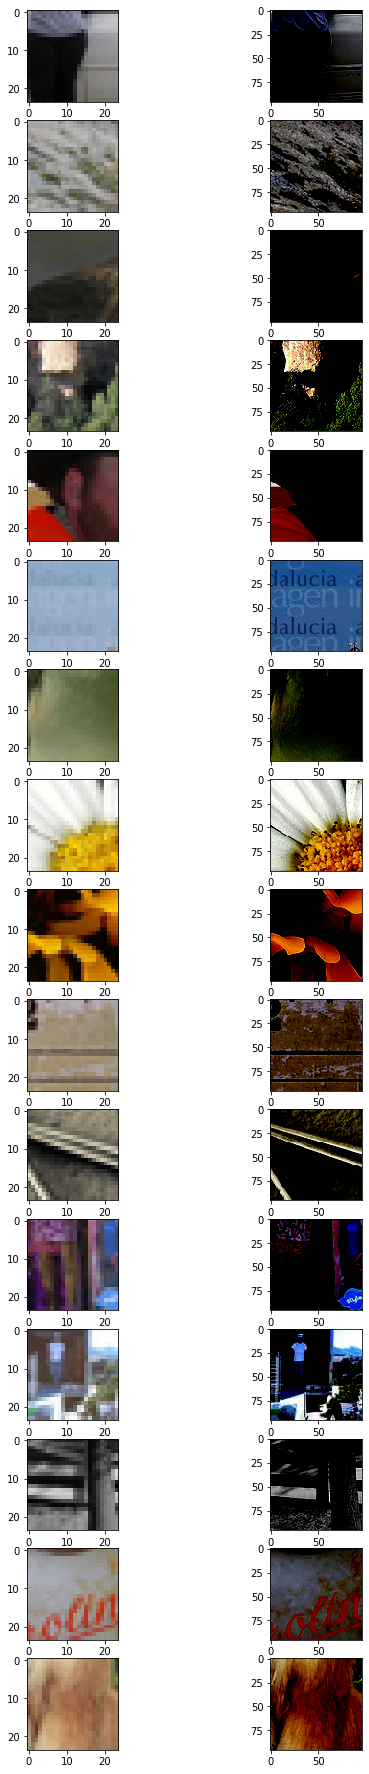

In [28]:
sample_batch = pipeline.show_results()

batch_idx = 0
fig,axes = plt.subplots(nrows=batch_size, ncols=2)
fig.set_figheight(32)
fig.set_figwidth(8)
for idx in range(batch_size):
    img = sample_batch[batch_idx]['lowres'][idx]
    img_hr = sample_batch[batch_idx]['highres'][idx]
    axes[idx, 0].imshow(img)
    axes[idx, 1].imshow(img_hr)
plt.show()

### Training details:

SRGAN shall be  trained for 200000 iterations.<br>
The learning rate is suggested to be 1e-4 for the first 100000 iterations and changed to 1e-5 for the next 1000000 iterations.

SRGAN's generator model is initialized from SRRESNET model weights. This helps with the GAN's stabilization.


In [29]:
class MyLRSchedule(LRSchedule):
    def schedule_fn(self, current_step_or_epoch, lr):
        if current_step_or_epoch <= 100000:
            lr = 0.0001
        elif current_step_or_epoch > 100000:
            lr = 0.00001
        return lr


![generator](./Figure/generator.png)

In [4]:
def get_G(input_shape):

    nin = Input(input_shape)
    n = Conv2D(64, 9, 1, padding='SAME', kernel_initializer='he_normal')(nin)
    n = PReLU(shared_axes=[1,2])(n)
    temp = n

    # B residual blocks
    for i in range(16):
        nn = Conv2D(64, 3, 1, padding='SAME', use_bias=False, kernel_initializer='he_normal')(n)
        
        nn = BatchNormalization()(nn)
        nn = PReLU(shared_axes=[1,2])(nn)

        nn = Conv2D(64, 3, 1, padding='SAME', use_bias=False, kernel_initializer='he_normal')(nn)
        nn = BatchNormalization()(nn)
        nn = Add()([n, nn])
        n = nn

    n = Conv2D(64, 3, 1, padding='SAME', use_bias=False, kernel_initializer='he_normal')(n)
    n = BatchNormalization()(n)
    n = Add()([n, temp])
    # B residual blacks end

    n = Conv2D(256, 3, 1, padding='SAME', kernel_initializer='he_normal')(n)
    n = SubPixelConv2D(upsample_factor=2, nchannels=64)(n)
    n = PReLU(shared_axes=[1,2])(n)

    n = Conv2D(256, 3, 1, padding='SAME', kernel_initializer='he_normal')(n)
    n = SubPixelConv2D(upsample_factor=2, nchannels=64)(n)
    n = PReLU(shared_axes=[1,2])(n)

    nn = Conv2D(3, 9, 1, padding='SAME', kernel_initializer='he_normal')(n)
    G = Model(inputs=nin, outputs=nn, name="generator")
    return G

![discriminator](./Figure/discriminator.png)

In [5]:
def get_D(input_shape):

        def d_block(layer_input, filters, strides=1, bn=True):
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same', kernel_initializer='he_normal')(layer_input)
            if bn:
                d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            return d

        # Input img
        d0 = Input(shape=input_shape)
        d1 = d_block(d0, 64, strides=1, bn=False)
        d2 = d_block(d1, 64, strides=2)
        d3 = d_block(d2, 128, strides=1)
        d4 = d_block(d3, 128, strides=2)
        d5 = d_block(d4, 256, strides=1)
        d6 = d_block(d5, 256, strides=2)
        d7 = d_block(d6, 512, strides=1)
        d8 = d_block(d7, 512, strides=2)
        
        d8 = Flatten()(d8)
        d9 = Dense(1024)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1)(d10)  # no activation is invoked to pass passing logit

        return Model(d0, validity)

### Generator loss

generator loss = content loss + adversarial loss
![total_loss](./Figure/total_loss_eq.png)


Content loss could be mse, vgg22 , vgg54<br>
MSE loss is mean square difference between pixels of super resolution images and high resolution images.
![mse_loss](./Figure/mse_loss_eq.png)
    

VGG22 and VGG54  introduce the concept, that rather than doing mse loss over pixel values, one may instead
send these images through VGG19 network, can attain the output at block2_conv2 or block5_conv3 layer, and it is these feature maps that the mse is carried upon, rather than the pixels.
![vgg_loss](./Figure/vgg_loss_eq.png)

SRRESNET model that is used to initialize the  SRGAN's generator model has been trained on MSE loss.
The current SRGAN implementation, has gone with VGG54 loss. Leveraging SubPixelConv2D layer from fastestimator for upsampling.

In [6]:
class GLoss(Loss):
    """Compute generator loss."""
    def __init__(self, inputs, outputs=None, mode=None, vgg_content=False, input_shape=(96,96,3)):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.vgg_content = vgg_content
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                                reduction=tf.keras.losses.Reduction.NONE)
        self.mse_loss = tf.losses.MeanSquaredError(reduction='none')
        # to calculate vgg loss
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
        vgg19.trainable = False
        for l in vgg19.layers:
            l.trainable = False
        self.vgg_model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        
    def vgg_preprocess(self , x):    
        x = 255.0 * (0.5 * (x + 1.0))
        mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3]) 
        x = x - mean
        x = x[:,:,:,::-1]
        return x
        
       
        
    def vgg_forward(self, superres, highres):
        superres = self.vgg_preprocess(superres)
        highres = self.vgg_preprocess(highres)
        superres = self.vgg_model(superres)
        highres = self.vgg_model(highres)
        return superres, highres
   
    
    def forward(self, data, state):
        superres, highres, fake = data
        batch_size, _,_,_ = superres.shape
        if self.vgg_content:
            superres, highres = self.vgg_forward(superres, highres)
            superres = tf.reshape(superres, (batch_size,-1))
            highres = tf.reshape(highres, (batch_size,-1))
            mse_loss = 0.006 * self.mse_loss(highres, superres)

        else:
            superres = tf.reshape(superres, (batch_size,-1))
            highres = tf.reshape(highres, (batch_size,-1))
            mse_loss = self.mse_loss(highres, superres)
        fake_loss = self.cross_entropy(tf.ones_like(fake), fake)
        total_loss = mse_loss + 0.001 * fake_loss
        return total_loss, mse_loss, 0.001*fake_loss
        

### Discriminator loss is standard GAN discriminator loss

In [7]:
import pdb
class DLoss(Loss):
    """Compute discrimator loss."""
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                                reduction=tf.keras.losses.Reduction.NONE)

    def forward(self, data, state):
        true, fake = data
        real_loss = self.cross_entropy(tf.ones_like(true), true)
        fake_loss = self.cross_entropy(tf.zeros_like(fake), fake)
        total_loss = real_loss + fake_loss
        return total_loss, real_loss, fake_loss
    

### Creation of the network 


In [14]:
model_gen = fe.build(model_def=os.path.join(model_read_dir,'srresnet_gen_best_mse_loss.h5'),
                 model_name="srgan_gen",
                 optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                 loss_name="mse_adv_loss", custom_objects={'SubPixelConv2D': SubPixelConv2D})
model_desc = fe.build( model_def= lambda : get_D(input_shape=(96,96,3)),
                      model_name="srgan_desc",
                      optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                      loss_name="desc_loss")


network = fe.Network(ops=[
    ModelOp(inputs= 'lowres', model=model_gen, outputs='superres'),
    ModelOp(inputs='superres', model=model_desc, outputs='pred_fake'),
    ModelOp(inputs='highres', model=model_desc, outputs='pred_true'),
    DLoss(inputs=("pred_true", "pred_fake"), outputs=("desc_loss","real_loss","fake_loss")),
    GLoss(inputs=('superres','highres', 'pred_fake'), outputs=("mse_adv_loss","mse_loss","adv_loss"), vgg_content=True)
])


### Create Estimator
Estimator api accepts network object, pipeline object , epochs, steps_per_epoch and trace object and returns an<br> estimator object which can orchestrate the training loop on the training data along with evaluaton on validation data.

### Traces
ModelSaver to save the best generator and  discriminator.
LRController engages LRSschedule to maintain the lr 1e-4 for iterations less than 100000 and 1e-5 greater than 100000 iterations.

In [35]:
estimator = fe.Estimator(
    network=network,
    pipeline=pipeline,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    traces=[
        ModelSaver(model_name="srgan_gen", save_dir=model_write_dir, save_best=True),
        ModelSaver(model_name="srgan_desc", save_dir=model_write_dir, save_best=True),
        LRController(model_name="srgan_gen", lr_schedule=MyLRSchedule(schedule_mode='step')),
        LRController(model_name="srgan_desc", lr_schedule=MyLRSchedule(schedule_mode='step'))
    ])


### Training begins

In [37]:
estimator.fit()

### Inference 

In [13]:
from tensorflow.keras.models import load_model
model_gen.load_weights(os.path.join(model_write_dir,'srgan_gen_best_mse_adv_loss.h5'))

### Determining PSNR(Peak signal to Noise ratio) and SSIM (Structural Similarity)
Note: One may download these set5 and set from 
http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_training_datasets.zip

In [44]:
imgs_pool = glob('/home/ubuntu/fastestimator_data/BSDS200/*.png')
set5_imgs = np.random.choice(imgs_pool, 5)

In [49]:
from skimage import io

def get_setimgs(set_imgs):
    set_hr,set_lr, set_sr = [], [], []
    for img in set_imgs:
        img = Image.open(img)
        width, height = img.size
        img_hr = np.array(img)
        set_hr.append(img_hr)
        img_lr_pil = img.resize((width//4, height//4),resample=PIL.Image.BICUBIC )
        img_lr = np.array(img_lr_pil)
        img_lr = img_lr /255
        set_lr.append(img_lr)
        
        img_lr = np.expand_dims(img_lr, axis=0)
        img_sr = model_gen(img_lr)
        img_sr = img_sr.numpy()
        img_sr = np.squeeze(img_sr)
        img_sr = np.clip(255 * 0.5 * (img_sr + 1.0), 0.0, 255.0).astype(np.uint8)
        set_sr.append(img_sr)
    return set_hr, set_lr, set_sr
set_hr,set_lr, set_sr = get_setimgs(set5_imgs)

In [47]:
from skimage.color import rgb2ycbcr,rgb2yuv
def luminance(image):
    lum = rgb2ycbcr(image)[:,:,0]
    lum = lum[4:lum.shape[0]-4, 4:lum.shape[1]-4]
    return lum

def get_psnr(set5_sr, set5_hr):
    psnr = []
    for idx,(sr, hr) in enumerate(zip(set5_sr, set5_hr)):
        sr = np.array(sr, np.uint8)
        if sr.shape == hr.shape:
            psnr.append( peak_signal_noise_ratio(luminance(hr),luminance(sr), data_range=255))
    psnr = np.array(psnr)
    return np.mean(psnr)

def get_ssim(set_sr, set_hr):
    ssim_list = []
    for idx,(sr, hr) in enumerate(zip(set_sr, set_hr)):
        sr = np.array(sr, np.uint8)
        if sr.shape == hr.shape:
            ssim_list.append(structural_similarity(luminance(sr), luminance(hr), data_range=255, multichannel=True))
    ssim_list = np.array(ssim_list)
    return np.mean(ssim_list)

def get_size(set5_sr, set5_hr):
    psnr = []
    for idx,(sr, hr) in enumerate(zip(set5_sr, set5_hr)):
        print(sr.shape, hr.shape)


get_psnr(set_sr, set_hr), get_ssim(set_sr, set_hr)

(29.47251094781036, 0.826796485977631)

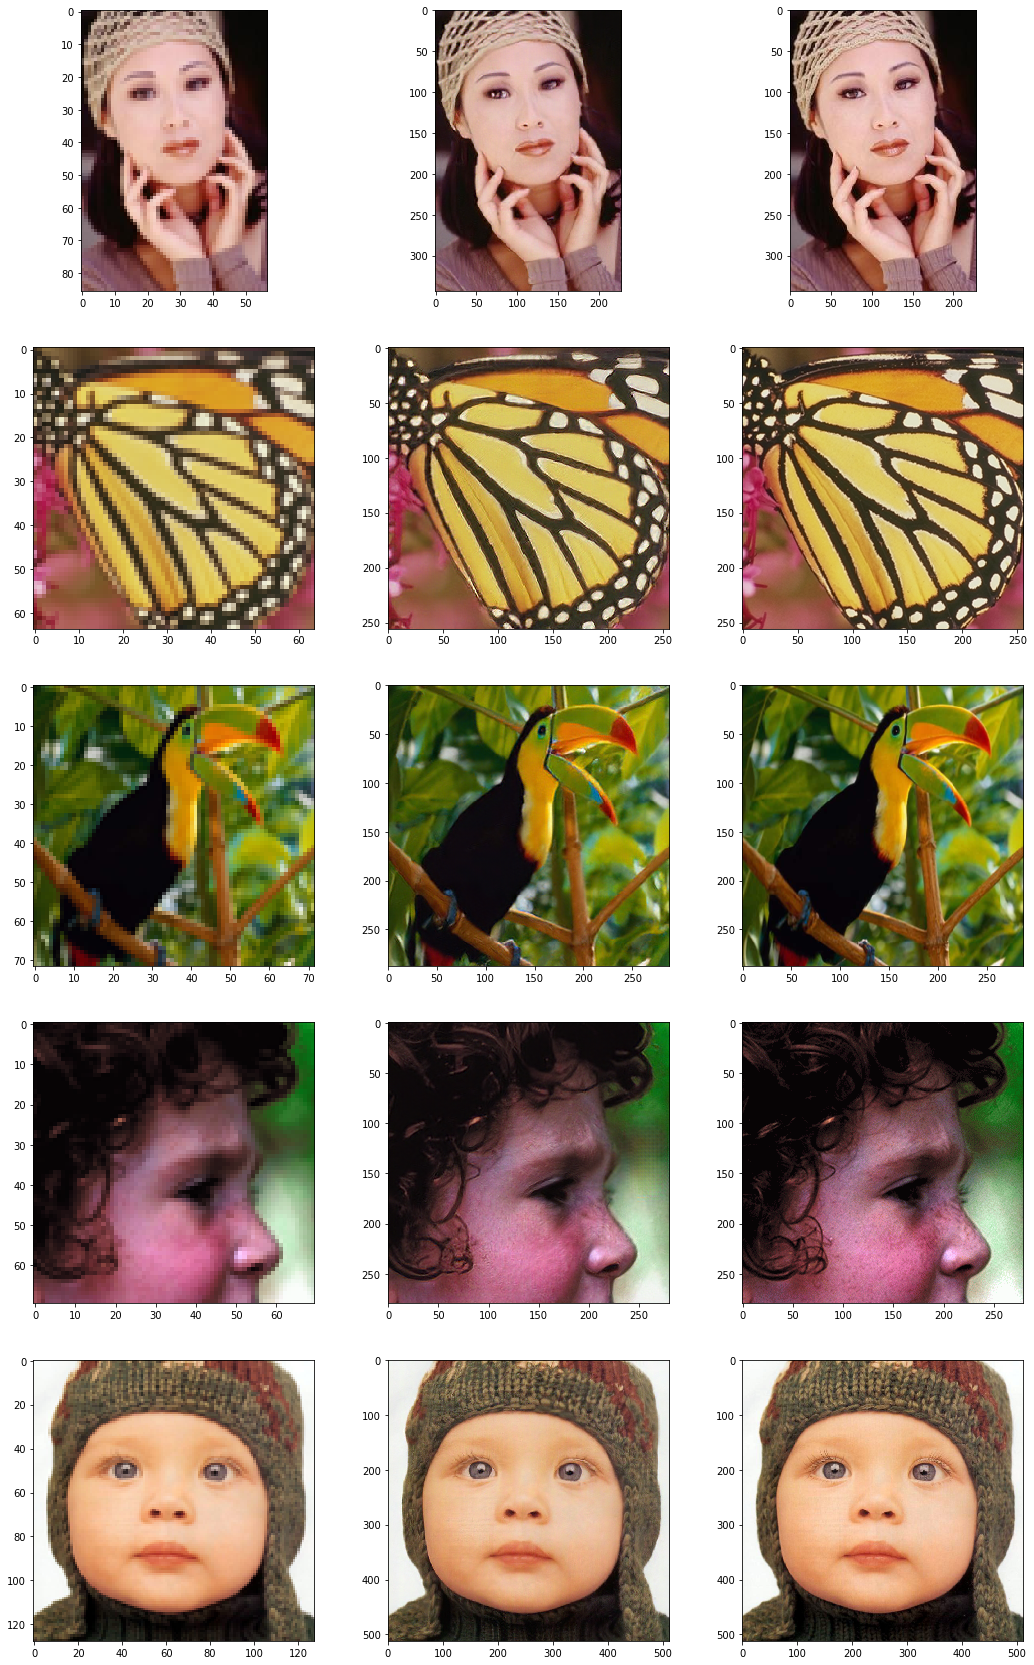

In [48]:
fig , axes = plt.subplots(nrows=5, ncols=3)
fig.set_figheight(30)
fig.set_figwidth(18)
for idx,(lr, sr, hr) in enumerate(zip(set_lr, set_sr, set_hr)):
    axes[idx, 0].imshow(lr)
    axes[idx, 1].imshow(sr)
    axes[idx, 2].imshow(hr)
plt.show()